In [1]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme
import matplotlib.pyplot as plt

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 1],  # activities
    [1, 1, 1],  # abundances
)


P, sequence_graph = simulate_proteolysis(
    hbb,
    n_start=10,
    n_iterations=100,
    endo_or_exo_probability=[0.1, .9],
    enzymes=enzymes,
)

 99 / 100

 4 / 500 | 9.67, mean: 7.81 | Decreasingg

/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/erikhartman/dev/disassembly/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 51 / 500 | 4.20, mean: 3.79 | Increasing
Learning rate decreased to 15.0
 151 / 500 | 0.74, mean: 2.15 | Increasing
Learning rate decreased to 7.5
 252 / 500 | 0.12, mean: 0.89 | Increasing
Learning rate decreased to 3.75
 477 / 500 | 0.05, mean: 0.04 | Increasing
Learning rate decreased to 1.875
 499 / 500 | 0.04, mean: 0.04 | Plateauing

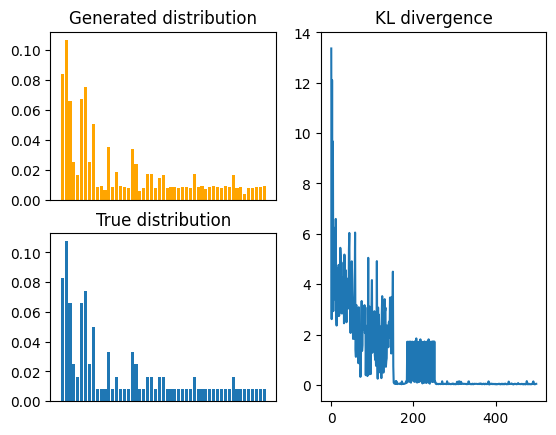

In [2]:
from disassembly.esimate_weights import estimate_weights

G, kls, generated, weights = estimate_weights(
    P=P,
    meta_enzyme=enzymes.meta_enzyme,
    exo_mult_factor=9,
    lr=30,
    n_iterations=500,
    N_T=1000,
)

fig, axs = plt.subplot_mosaic(
    [["generated", "kl"], ["true", "kl"]], width_ratios=[2, 2]
)

generated_sum = {k: 0 for k in generated[0].keys()}

for p_generated in [
    generated[i]
    for i in range(
        len(generated.keys()) - int(len(generated.keys()) / 20), len(generated.keys())
    )
]:
    for k, v in p_generated.items():
        generated_sum[k] += v / 20

axs["true"].bar(P.keys(), [v / sum(P.values()) for v in P.values()])
axs["generated"].bar(
    generated_sum.keys(),
    [v / sum(generated_sum.values()) for v in generated_sum.values()],
    color="orange",
)
axs["kl"].plot(kls)
axs["true"].set_title("True distribution")
axs["generated"].set_title(f"Generated distribution")
axs["kl"].set_title("KL divergence")
axs["true"].set_xticks([])
axs["generated"].set_xticks([])
plt.show()

In [3]:
real_vs_estimated_weights = []
for node in sequence_graph.nodes():
    sum_out_edges = sum(
        [data["weight"] for _, _, data in sequence_graph.out_edges(node, data=True)]
    )
    for source, target, data in sequence_graph.out_edges(node, data=True):
        real_weight = data["weight"] / sum_out_edges
        estimated_weight = G[source][target]["weight"]
        real_vs_estimated_weights.append((real_weight, estimated_weight))

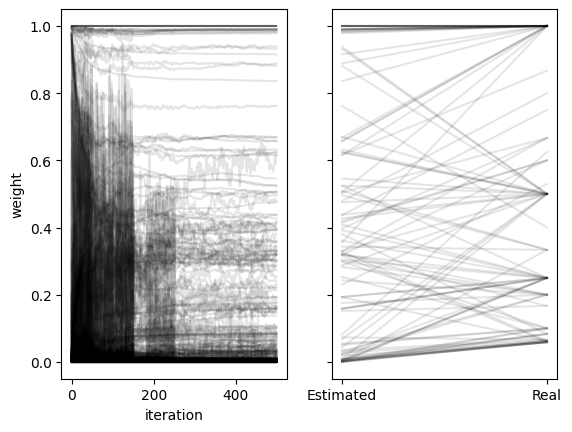

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].set_ylabel("weight")
axs[0].plot(weights.T, alpha=0.1, color="black")
for r, e in real_vs_estimated_weights:
    axs[1].plot([0, 1], [e, r], alpha=0.1, color="black")
axs[1].set_xticks([0, 1], ["Estimated", "Real"])
axs[0].set_xlabel("iteration")

plt.show()

In [5]:
from disassembly.disassembly import get_disassembly_indexes
from disassembly.disassembly import get_disassembly

real_disassembly_indexes = get_disassembly_indexes(sequence_graph)
print(sequence_graph.number_of_edges())
get_disassembly(P, real_disassembly_indexes)

 52 / 53 | checking 1 path58


11.00226792413545

In [6]:
import networkx as nx

no_0_G = nx.DiGraph()
for source, target, data in G.edges(data=True):
    if data["weight"] > 0.0001:
        no_0_G.add_edge(source, target, **data)

print(no_0_G.number_of_edges())

estimated_disassembly_indexes = get_disassembly_indexes(no_0_G)
get_disassembly(P, estimated_disassembly_indexes)

269
 52 / 53 | checking 71 pathhh

4.8048498713016095

Text(0, 0.5, 'Estimated')

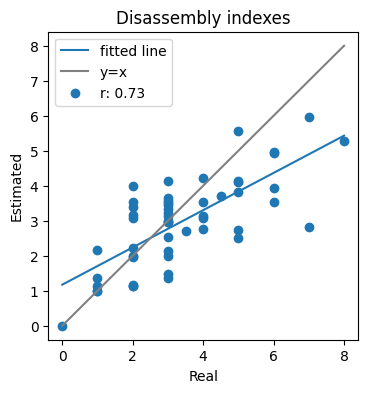

In [7]:
from scipy.stats import linregress
import numpy as np


fig = plt.figure(figsize=(4, 4))
xs = []
ys = []
for key in P.keys():
    xs.append((real_disassembly_indexes[key]))
    ys.append((estimated_disassembly_indexes[key]))

regress = linregress(xs, ys)

plt.plot(np.linspace(0, max(xs)), regress.intercept + np.linspace(0, max(xs)) * regress.slope, label="fitted line")

plt.plot(np.linspace(0, max(xs)), np.linspace(0, max(xs)), color="gray", label="y=x")
plt.scatter(xs, ys, label=f"r: {regress.rvalue:.2f}")
plt.legend()
plt.title("Disassembly indexes")

plt.xlabel("Real")
plt.ylabel("Estimated")